In [28]:
%matplotlib inline
import numpy as np
from astropy.io import fits as pf
import matplotlib
from matplotlib import pyplot as plt
import scipy
import scipy.interpolate as sciinterp
import scipy.constants

In [2]:
def openFile(filename):
    
    """Given the filename of a fits file extracts the data.
       Works on both flux and wavlength solution files."""
    
    file = pf.open(filename)
    
    return file[0].data

In [3]:
def rms2Spectra(spec1, spec2):
    
    """Determines the RMS value between two spectra 
       using N-1 normalization. """
    
    assert len(spec1) == len(spec2)
    diff = np.array([])
    for fluxval in range(len(spec1)):
        diff = np.append(diff, spec1[fluxval] - spec2[fluxval])
    diffsquares = diff**2
    sumsquares = np.sum(diffsquares)
    normed = sumsquares/(len(spec1) - 1)
    return normed**(0.5)

In [4]:
def sectionAndAverage(wavelengths, flux, sections):
    
    """Split the wavelength and flux into bins of approximately 
       the same size according to sections value. Remove the values
       at or below the 5th percentile of brightness. Take the average
       of the remaining brightness values. Choose a wavelength 
       value that corresponds to the center of the bin."""
    
    #Find average flux of each bin after removing
    #Lowest flux values (bottom 5th percentile)
    flux_blocks = np.array_split(flux, sections)
    medians = np.array([])
    for section in flux_blocks:
        percentile5 = np.percentile(section, 40)
        morethan5th = section[section > percentile5]
        sectionmed = np.median(morethan5th)
        medians = np.append(medians, sectionmed)
    
    #Find wavelength value for bins
    wavesections = np.array_split(wavelengths, sections)
    points = np.array([])
    for section in wavesections:
        section_point = section[int(len(section)/2)]
        points = np.append(points, section_point)
        
    return points, medians

In [27]:
def removeBlazev2(wavelength, flux, sections, polydegree):
    
    """This version of blaze function removal does not normalize the
       flux or center the wavelengths before determining the polynomial
       coefficients, but normalizes with the division of the blaze function."""
    
    #Split spectra and wavelength solution into bins, average the 
    #appropriate flux values based on percentile, take mid-bin 
    #wavelength value to correspond to the bin's average
    points, medians = sectionAndAverage(wavelength, flux, sections)
    
    #Calculate the polynomial coefficients based on the above values
    coef = np.polyfit(points, medians, polydegree)
    curve_fit = np.poly1d(coef)
    
    #Calculate RMS between the spectra and the fit, large RMS
    #Value given non-normalized spectra
    rmsNB = rms2Spectra(flux, curve_fit(wavelength))
    
    #Plot the fit with the median point values used 
    fig, ax = plt.subplots(1, 1, figsize = (11, 6))
    fig.subplots_adjust(hspace=0)
    ax.scatter(wavelength, curve_fit(wavelength))
    ax.scatter(points, medians)
    ax.title.set_text("Polyfit Through Points Used - 10 Section Bottom 40 Percentile Removed 5th Degree")
    ax.set_ylabel("Flux")
    plt.xlabel("Wavelength (A)")
    plt.show()
    
    #Plot the fit with the residuals
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
    fig.subplots_adjust(hspace=0)
    ax1 = axs[0]
    ax1.plot(wavelength, flux)
    ax1.plot(wavelength, curve_fit(wavelength), "ro")
    #ax1.title.set_text("Polynomial Blaze Function Fit 10 Sections - Bottom 40 Percentile Removed - 5th Degree")
    ax1.title.set_text("Polynomial Fit Order 25")
    ax1.set_ylabel("Normalized Flux")
    ax2 = axs[1]
    ax2.plot(wavelength, flux - curve_fit(wavelength))
    ax2.set_ylabel("Residuals")
    plt.xlabel("Wavelength (A)")
    plt.show()
    
    #Return the flux with the blaze function divided out
    return flux/curve_fit(wavelength)

In [6]:
def sciinterpolate(new_bins, old_bins, old_flux, method = "linear"):
    
    interpfunc = sciinterp.interp1d(old_bins, old_flux, kind = method, fill_value = 2000, bounds_error=False)
    new_flux = interpfunc(new_bins)
    
    return new_flux

In [7]:
def deltalambda(wavelengths, velocity):

    """Create new wavlength bins constant in deltalambda/lambda."""
    
    c = scipy.constants.c
    new_wavelengths = np.array([])
    new_wavelengths = np.append(new_wavelengths, wavelengths[0])
    for i in range(len(wavelengths) - 1):
        y1 = wavelengths[i]
        delta = velocity*y1/c
        y2 = y1 + delta
        new_wavelengths = np.append(new_wavelengths, y2)
        y1 = y2
    return new_wavelengths

In [8]:
def shiftSpectra(wavelength, flux1NB, flux2NB, maxshift):
    
    allRMS = np.array([])
    shiftVals = np.array([])
    for i in range(-maxshift, maxshift + 1):
        #make a copy of the flux so rolling does
        #not affect original data
        copyflux1 = np.copy(flux1NB)
        copyflux2 = np.copy(flux2NB)
        #shift flux by i
        copyflux2 = np.roll(copyflux2, i)
        #truncate flux arrays
        copyflux1 = copyflux1[abs(i):len(copyflux1) - abs(i)]
        copyflux2 = copyflux2[abs(i):len(copyflux2) - abs(i)]
        #calculate new rms
        shiftRMS = rms2Spectra(copyflux1, copyflux2)
        #store RMS value
        allRMS = np.append(allRMS, shiftRMS)
        #store shift value for the rms
        shiftVals = np.append(shiftVals, i)
    index = np.argmin(allRMS)
    shift = int(shiftVals[index])
    print(shift)
    truncwave = wavelength[abs(shift): len(wavelength) - abs(shift)]
    truncflux1 = flux1NB[abs(shift): len(flux1NB) - abs(shift)]
    truncflux2 = np.roll(flux2NB, - abs(shift))[abs(shift): len(flux2NB) - abs(shift)]
    
    return truncwave, truncflux1, truncflux2

In [9]:
flux1 = openFile("rarp.210.fits")
flux2 = openFile("rbdl.232.fits")
wavelength = openFile("apf_wave_mod.fits")

In [10]:
wavelength25 = wavelength[25]
flux125 = flux1[25]
flux225 = flux2[25]

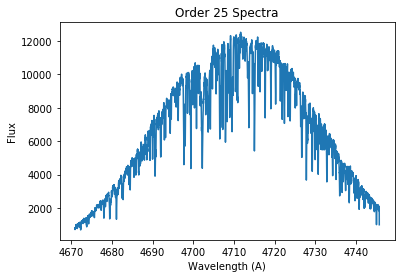

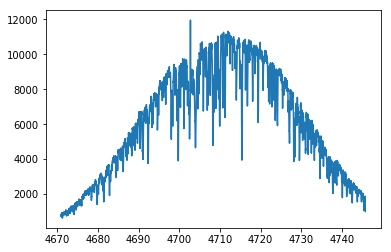

In [12]:
plt.plot(wavelength25, flux125)
plt.title("Order 25 Spectra")
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.show()
plt.plot(wavelength25, flux225)
plt.show()

In [26]:
deltalambda1 = deltalambda(wavelength25, 1300)
print(max(deltalambda1) - max(wavelength25))

0.00910663182549


In [27]:
newflux1 = sciinterpolate(deltalambda1, wavelength25, flux125, method = 'cubic')
newflux2 = sciinterpolate(deltalambda1, wavelength25, flux225, method = 'cubic')

In [28]:
rmslambda = rms2Spectra(newflux1, newflux2)

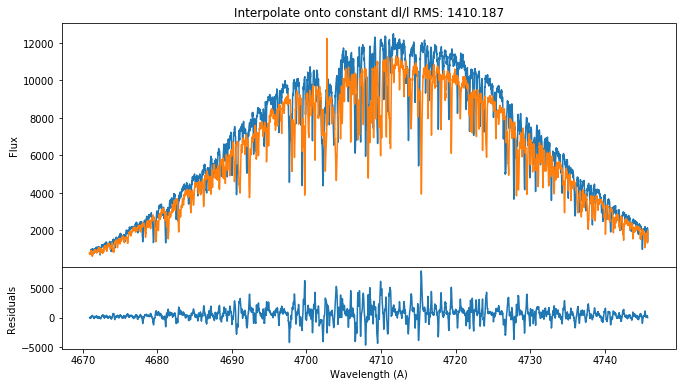

In [29]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(deltalambda1, newflux1)
ax1.plot(deltalambda1, newflux2)
ax1.title.set_text("Interpolate onto constant dl/l RMS: " + str(np.round(rmslambda, 3)))
ax1.set_ylabel("Flux")
ax2 = axs[1]
ax2.plot(deltalambda1, newflux1 - newflux2)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

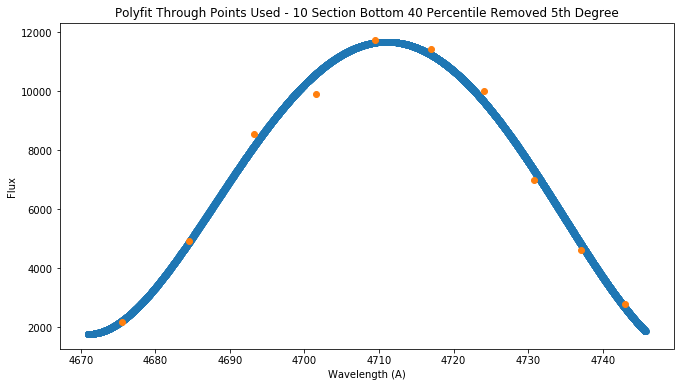

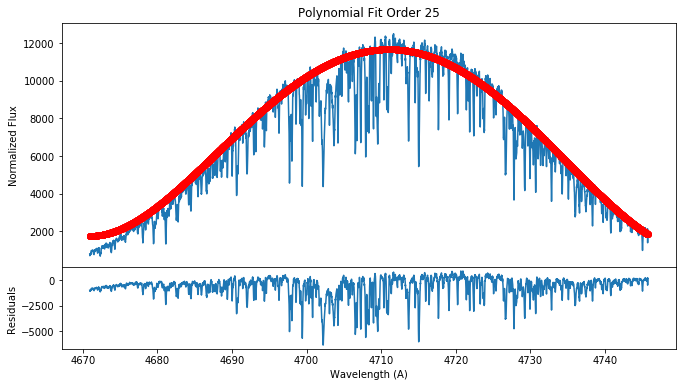

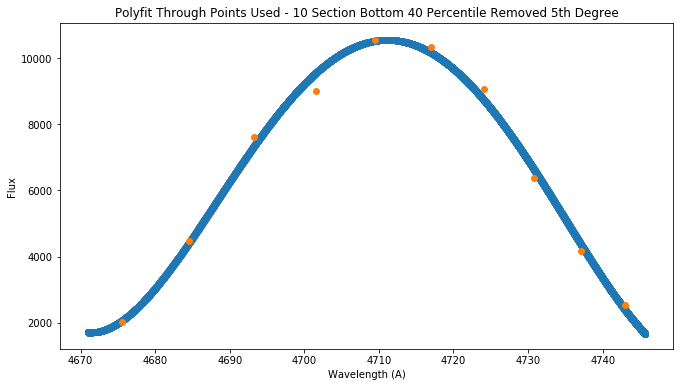

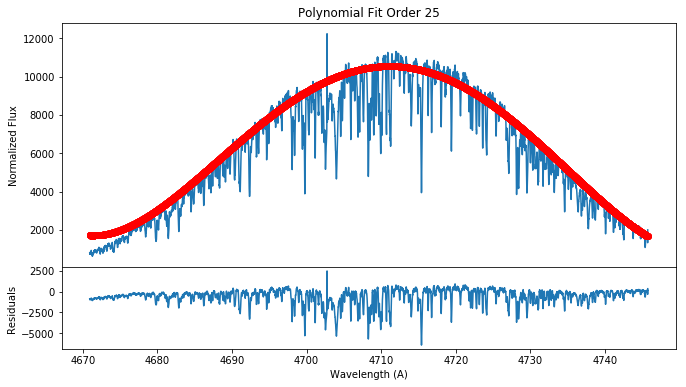

In [30]:
newflux1NB = removeBlazev2(deltalambda1, newflux1, 10, 4)
newflux2NB = removeBlazev2(deltalambda1, newflux2, 10, 4)

In [17]:
rmsNB = rms2Spectra(newflux1NB, newflux2NB)

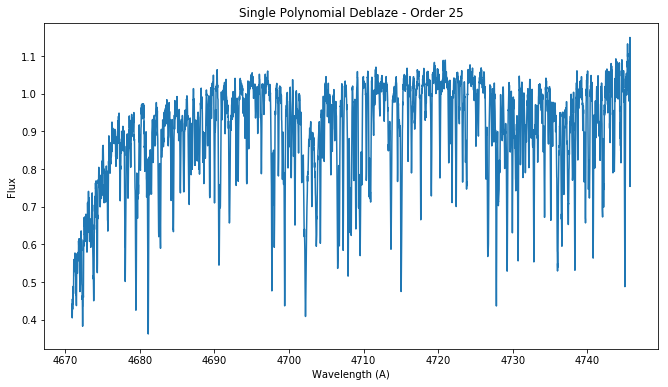

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (11, 6))
fig.subplots_adjust(hspace=0)
ax.plot(deltalambda1, newflux1NB)
ax.title.set_text("Single Polynomial Deblaze - Order 25")
ax.set_ylabel("Flux")
plt.xlabel("Wavelength (A)")
plt.show()

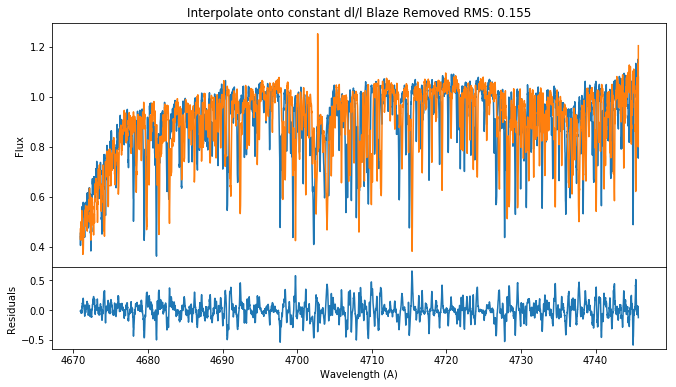

In [32]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(deltalambda1, newflux1NB)
ax1.plot(deltalambda1, newflux2NB)
ax1.title.set_text("Interpolate onto constant dl/l Blaze Removed RMS: " + str(np.round(rmsNB, 3)))
ax1.set_ylabel("Flux")
ax2 = axs[1]
ax2.plot(deltalambda1, newflux1NB - newflux2NB)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

In [486]:
shiftwav, shiftf1, shiftf2 = shiftSpectra(deltalambda1, newflux1NB, newflux2NB, 200)

-21


In [487]:
rmsShift = rms2Spectra(shiftf1, shiftf2)

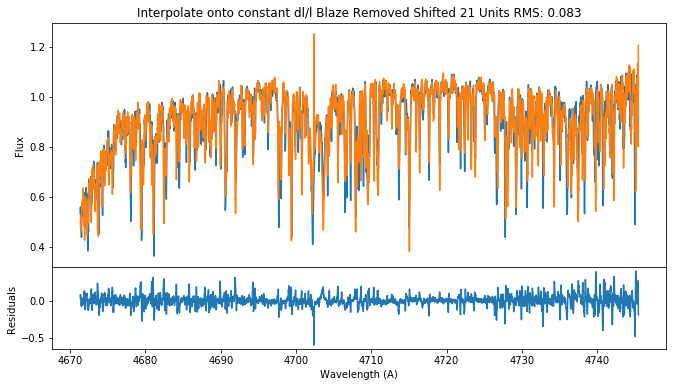

In [488]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(shiftwav, shiftf1)
ax1.plot(shiftwav, shiftf2)
ax1.title.set_text("Interpolate onto constant dl/l Blaze Removed Shifted 21 Units RMS: " + str(np.round(rmsShift, 3)))
ax1.set_ylabel("Flux")
ax2 = axs[1]
ax2.plot(shiftwav, shiftf1 - shiftf2)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

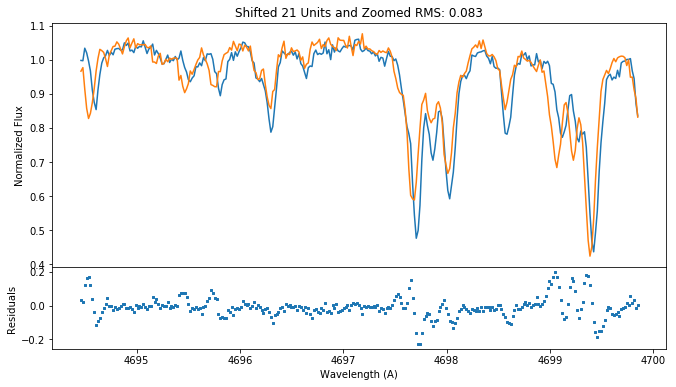

In [489]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(shiftwav[1200:1500], shiftf1[1200:1500])
ax1.plot(shiftwav[1200:1500], shiftf2[1200:1500])
ax1.title.set_text("Shifted 21 Units and Zoomed RMS: " + str(np.round(rmsShift, 3)))
ax1.set_ylabel("Normalized Flux")
ax2 = axs[1]
ax2.scatter(shiftwav[1200:1500], shiftf1[1200:1500] - shiftf2[1200:1500], marker = 's', s = 1.5)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

## 3 Orders

In [503]:
wavelength24 = wavelength[24]
wavelength25 = wavelength[25]
wavelength26 = wavelength[26]
flux24 = flux1[24]
flux25 = flux1[25]
flux26 = flux1[26]

In [500]:
deltalambda1 = deltalambda(wavelength24, 1300)
deltalambda2 = deltalambda(wavelength25, 1300)
deltalambda3 = deltalambda(wavelength26, 1300)

In [501]:
newflux1 = sciinterpolate(deltalambda1, wavelength24, flux24, method = 'cubic')
newflux2 = sciinterpolate(deltalambda2, wavelength25, flux25, method = 'cubic')
newflux3 = sciinterpolate(deltalambda3, wavelength26, flux26, method = 'cubic')

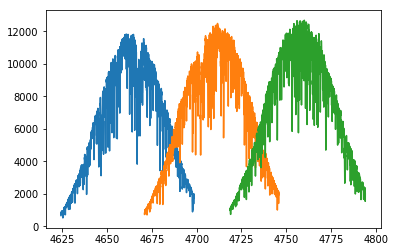

In [504]:
plt.plot(deltalambda1, newflux1)
plt.plot(deltalambda2, newflux2)
plt.plot(deltalambda3, newflux3)
plt.show()

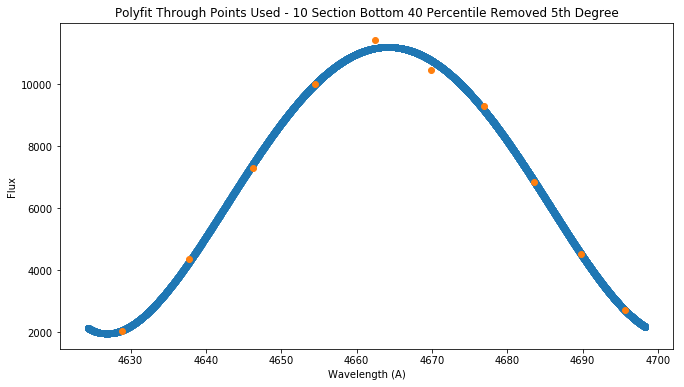

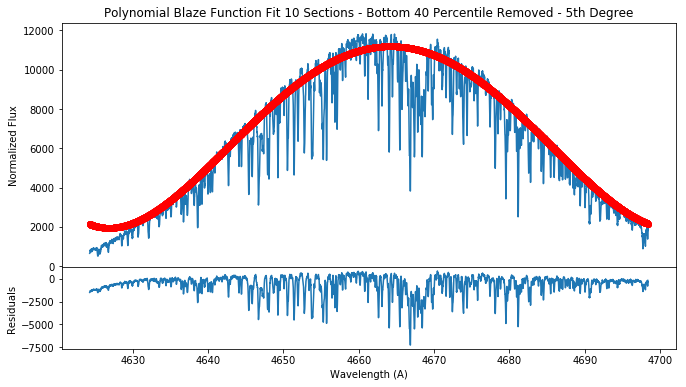

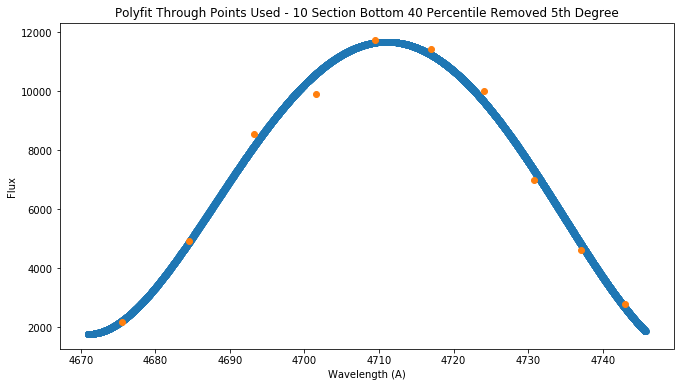

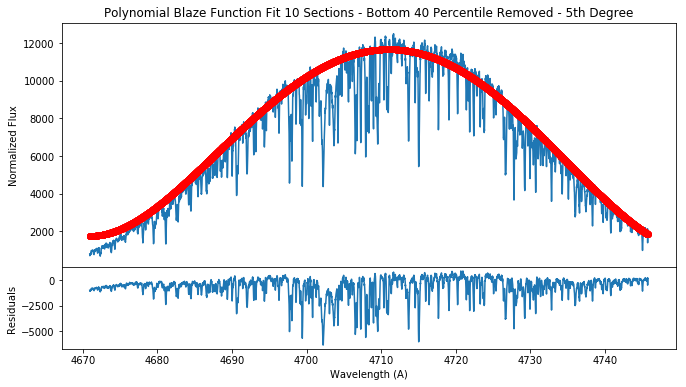

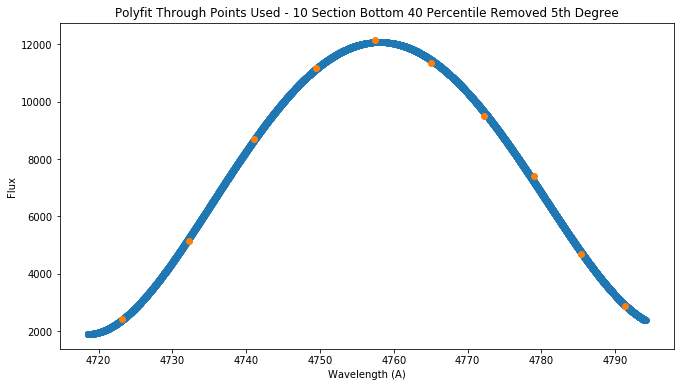

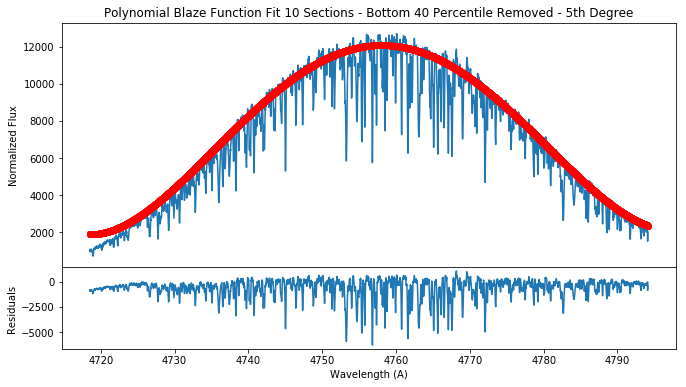

In [506]:
newflux1NB = removeBlazev2(deltalambda1, newflux1, 10, 4)
newflux2NB = removeBlazev2(deltalambda2, newflux2, 10, 4)
newflux3NB = removeBlazev2(deltalambda3, newflux3, 10, 4)

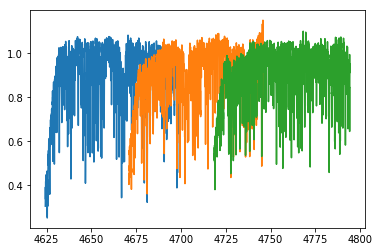

In [507]:
plt.plot(deltalambda1, newflux1NB)
plt.plot(deltalambda2, newflux2NB)
plt.plot(deltalambda3, newflux3NB)
plt.show()